# P&D ISSP 2023 - Base notebook
@Students: Edit everything you want!

Packages

In [10]:
import matplotlib
import soundfile
import os
import package.general as genfcns
import package.gui_utils as guifcns
matplotlib.style.use('default')  # <-- for notebooks: white figures background

# Root path (path to where you are storing this very notebook)
#  /!/  Adapt this to your system  /!/ 
ROOTPATH = 'C:/Yani/Signal_Processing_Project'

pathToSoundFiles = f'{ROOTPATH}/sound_files/'

# Parameters
speechfilenames = [
    pathToSoundFiles + 'speech1.wav',
    pathToSoundFiles + 'speech2.wav'
]
noisefilenames = [
    pathToSoundFiles + 'Babble_noise1.wav'
]
signalDuration = 10     # [s]
muGSC = 0.1     # NLMS update constant for freq.-domain GSC

Build acoustic scenario and generate RIRs using GUI

In [9]:
def gui():# Launch GUI
    guifcns.RIRg_GUI(
        exportFolder=f'{os.getcwd()}/rirs',
        outputRIRplot=False,
        distBwMics=10,  # [cm]
        fs=44100,
        t60=0,
        theme='SystemDefault',
    )

RIRs selection

In [8]:
def build(): # Select RIRs to be used
    # RIR_FILE = 'rirs/'  # use this to input a specific set of RIRs (full path to .pkl.gz file)
    RIR_FILE = genfcns.select_latest_rir(path='./rirs/')  # use this to select the lastly generated RIRs
    # Load from Pickle archive
    acousticScenario = guifcns.load_rirs(path=RIR_FILE)
    # Show to user
    acousticScenario.plot_asc()
    return acousticScenario

In [111]:
# ... Up to you, now!
roomDim = acousticScenario.roomDim # access the room dimension [m]
print(acousticScenario) # print out all parameters


Acoustic scenario object containing the RIRs, with parameters:
>> Field "audioCoords": [[1.05, 0.8999999999999999]]
>> Field "audioIds": ['61']
>> Field "c": 340
>> Field "distBwMics": 0.1
>> Field "exportFolder": c:\Yani\Signal_Processing_Project/rirs
>> Field "fs": 16000
>> Field "lineIds": [1, 3, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57]
>> Field "lineTextIds": [2, 5, 7, 9, 11, 13, 15, 17, 19, 21, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58]
>> Field "micsCoords": [[3.0, 2.9], [3.0, 3.0]]
>> Field "micsIds": ['59', '60']
>> Field "nMicsPerArray": 5
>> Field "noiseCoords": []
>> Field "noiseIds": []
>> Field "numMics": 2
>> Field "rirLength": 22050
>> Field "roomDim": 10.0
>> Field "t60": 0.35
>> Field "theme": SystemDefault



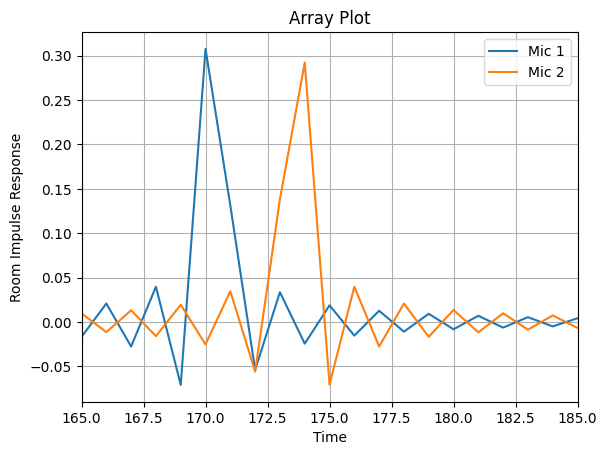

In [ ]:
# Plot the array
gui()
acousticScenario = build()
import matplotlib.pyplot as plt
plt.plot(acousticScenario.RIRsAudio[:,0,0])
plt.plot(acousticScenario.RIRsAudio[:,1,0])
# Labels and title
plt.xlabel('Time')
plt.legend(['Mic 1', 'Mic 2'])
plt.ylabel('Room Impulse Response')
plt.title('Array Plot')
plt.xlim([165, 185])
plt.grid()
# Show the plot
plt.show()


In [16]:
import scipy.io.wavfile as wav
import librosa
import librosa.display
import numpy as np
from scipy.signal import fftconvolve,resample,correlate
def create_micsigs(acousticScenario, audio_src, noise_src):
    start_time = 0  # seconds
    end_time = 10    # seconds
    sample_rate_audio = []
    sample_rate_noise = []
    processed_audio = []
    processed_noise = []
    for i in range(0,acousticScenario.RIRsAudio.shape[2]):
        sample_rate_audio, audio = wav.read(audio_src[i])
        start_sample_audio = int(start_time * sample_rate_audio)
        end_sample_audio = int(end_time * sample_rate_audio)

        audio = audio[start_sample_audio:end_sample_audio]

        num_samples = int(len(audio)* acousticScenario.fs/sample_rate_audio)
        unnorm_audio =resample(audio,num_samples)
        processed_audio.append(unnorm_audio / np.max(np.abs(unnorm_audio)))
    if acousticScenario.RIRsNoise is None:
        pass
    else:
        for i in range(0,acousticScenario.RIRsNoise.shape[2]):
            sample_rate_noise, noise = wav.read(noise_src[i])
            start_sample_noise = int(start_time * sample_rate_noise)
            end_sample_noise = int(end_time * sample_rate_noise)

            noise = noise[start_sample_noise:end_sample_noise]

            num_samples = int(len(noise)* acousticScenario.fs/sample_rate_noise)
            unnorm_noise =resample(noise,num_samples)
            processed_noise.append( unnorm_noise / np.max(np.abs(unnorm_noise)))



    mic = []
    for i in range (0,acousticScenario.RIRsAudio.shape[1]):
        mic_total = 0
        for j in range (0,acousticScenario.RIRsAudio.shape[2]):
            mic_audio = fftconvolve(processed_audio[j], acousticScenario.RIRsAudio[:,i,j], mode='full')
            mic_total = mic_total + mic_audio

        if acousticScenario.RIRsNoise is None:
            pass
        else:
            for j in range (0,acousticScenario.RIRsNoise.shape[2]):
                mic_noise = fftconvolve(processed_noise[j], acousticScenario.RIRsNoise[:,i,j], mode='full')
                mic_total = mic_total + mic_noise

        norm_mic = mic_total / np.max(np.abs(mic_total))
        mic.append(norm_mic)

    # Plot the array
    plt.plot(mic[0])
    plt.plot(mic[1])
    # Labels and title
    plt.xlabel('Time')
    plt.ylabel('Mic Signal')
    plt.title('Microphone 1 and 2')
    plt.grid()
    #plt.xlim([150, 180])
    # Show the plot
    plt.show()

    return mic, processed_audio, processed_noise


In [7]:
print(acousticScenario.fs)
speechfilenames = [
    pathToSoundFiles + 'speech1.wav',
    pathToSoundFiles + 'whitenoise_signal_1.wav'
]
noisefilenames = [
    pathToSoundFiles + 'whitenoise_signal_1.wav',
    pathToSoundFiles + 'whitenoise_signal_2.wav'
]


mict, aud, noise = create_micsigs(acousticScenario, speechfilenames, noisefilenames)
soundfile.write("output.wav", mict[0], acousticScenario.fs)

NameError: name 'acousticScenario' is not defined

In [201]:
acousticScenario.RIRsAudio.shape

(22050, 5, 2)

In [96]:
Gnd_truth = -3+len(mict[0]) - 1

In [8]:
def TDOA_corr(mic1, mic2, n=1, start = 0, stop = -1):
    # Cross-correlation of the two microphone signals

    xcorr = correlate(mic1, mic2, mode='full')
    # Time delay of arrival
    TDOA_list = []
    for i in range(n):
        TDOA_list.append( np.argmax(xcorr) - len(mict[0]) + 1)
        xcorr = np.delete(xcorr, np.argmax(xcorr))

    # Plot the cross-correlation
    plt.plot(xcorr)
    plt.xlabel('Time')
    plt.ylabel('Cross-correlation')
    plt.title('Cross-correlation of the two microphone signals')
    plt.grid()
    if stop !=-1:
        plt.xlim([start, stop])
    #plt.stem(Gnd_truth, xcorr[Gnd_truth], 'r')
    plt.show()
    return TDOA_list

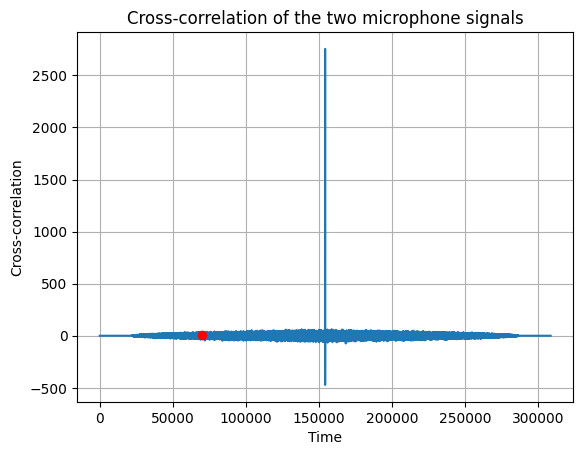

[10]


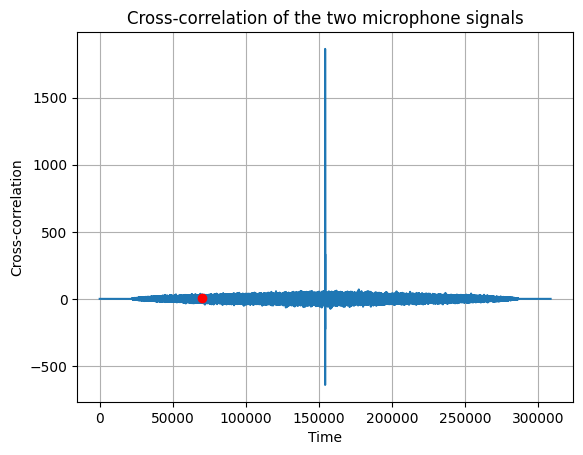

[20]


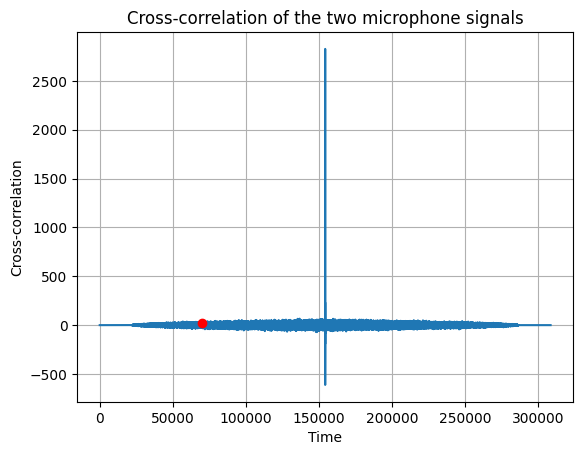

[-28]


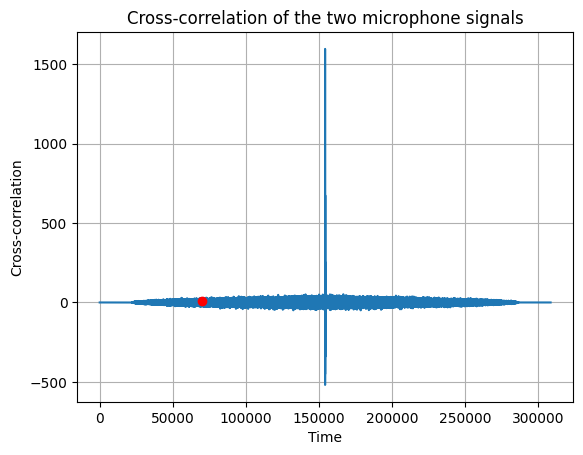

[40]


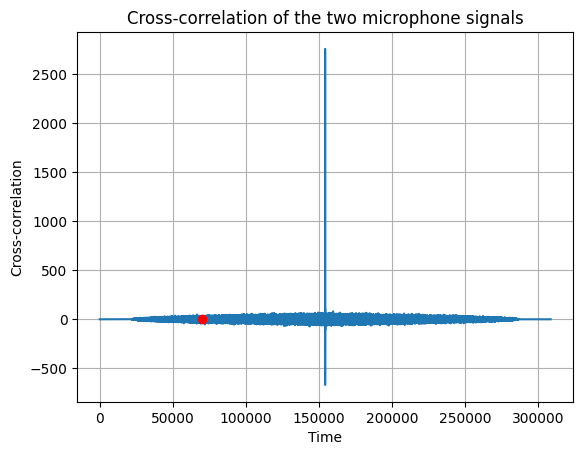

[10]


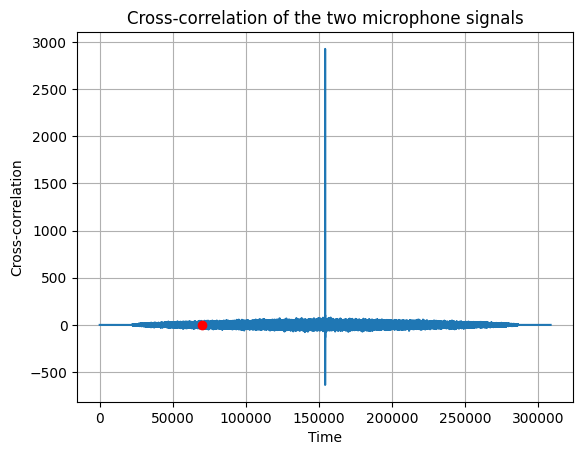

[20]


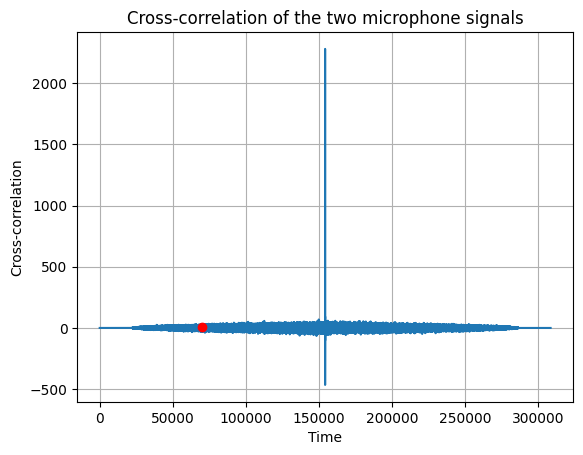

[30]


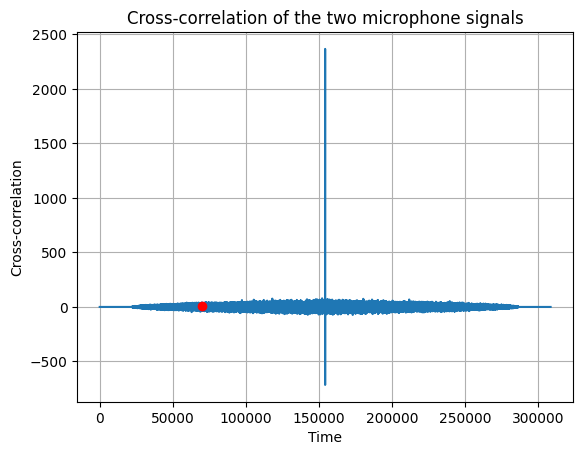

[10]


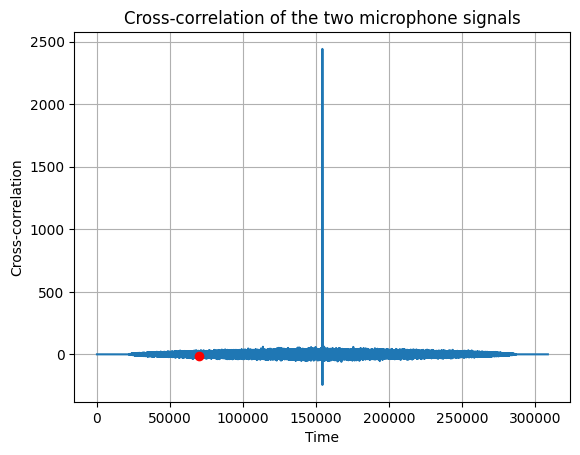

[20]


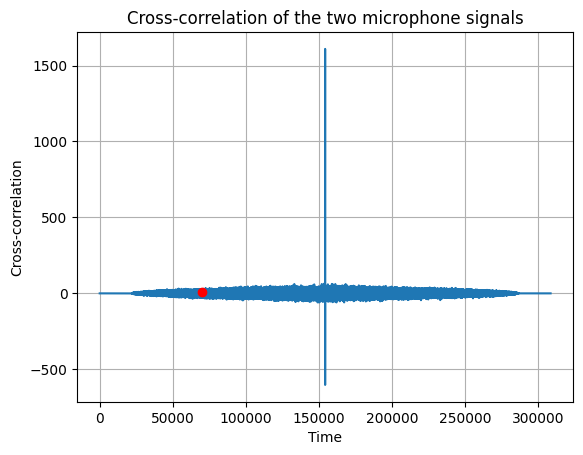

[10]


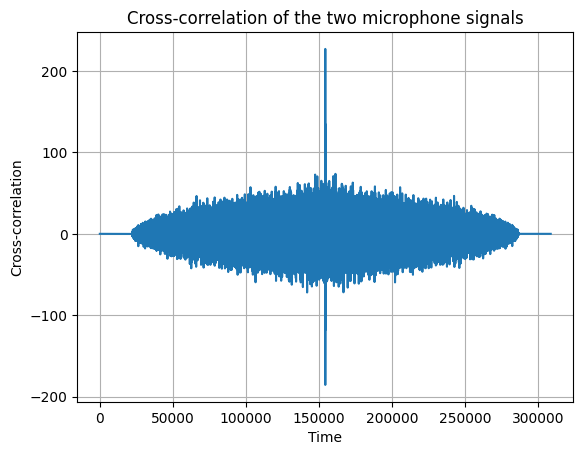

In [335]:
TDOA= TDOA_corr(mict[0], mict[1], n = 1)

In [148]:
print(TDOA)

[-7]


In [11]:
def DOA_corr( TDOA, fs, d):
    DOAestAll = []
    for i in range(0,len(TDOA)):
            
        # Speed of sound
        c = 340  # [m/s]
        # Distance between microphones
        # Time delay of arrival
        tau = TDOA[i]/fs
        # Angle of arrival
       # print(tau), print(d), print(c), print(np.arccos(c*tau/d))
        if c*tau/d >= 1:
            DOA =0
        elif c*tau/d <= -1:
            DOA = np.pi
        else:
            DOA = np.arccos(c*tau/d) #*180/np.pi
        DOAestAll.append(DOA)
    return DOAestAll

In [174]:
print(DOAestAll[0]*180/np.pi)

112.67400995037752


Oracle-selected estimated DOAs: [46.06216011]
Target DOAs estimate error(s): [-88.5] deg.


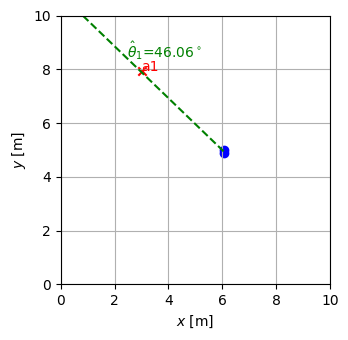

In [336]:

DOAestAll = DOA_corr(TDOA, acousticScenario.fs,0.1)

# Oracle selection of the target DOA
DOAest, oracleDOAtalkers = genfcns.oracle_choice_doa(
    DOAestAll, acousticScenario
)
print(f'Oracle-selected estimated DOAs: {DOAest * 180/np.pi}')
# Check validity
genfcns.check_plot_tdoas(DOAest, DOAestAll, acousticScenario)
print(f'Target DOAs estimate error(s): {np.round((DOAest - oracleDOAtalkers) * 180/np.pi, 1)} deg.')

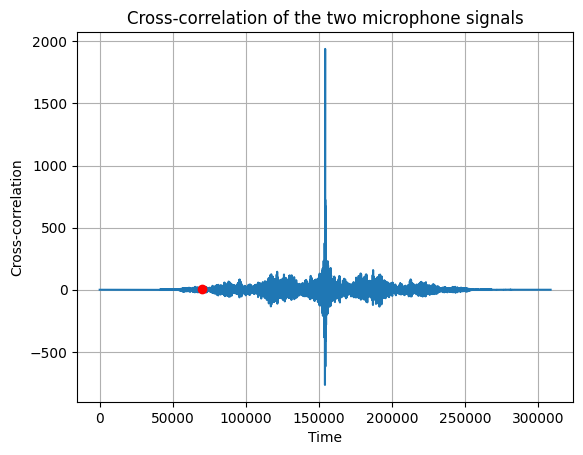

0.0
0.1
340
1.5707963267948966
-2.2675736961451248e-05
0.1
340
1.6479704157421002
0 1
90.0
94.421749584442
[0, -1]


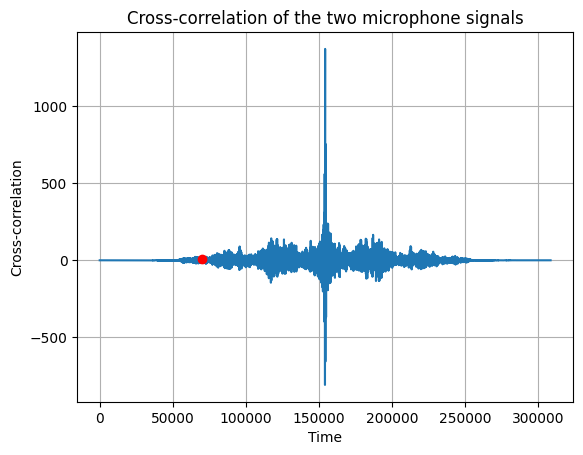

-0.00020408163265306123
0.2
340
1.925101495769374
-0.00020408163265306123
0.2
340
1.925101495769374
0 2
110.30019084190704
110.30019084190704
[-9, -9]


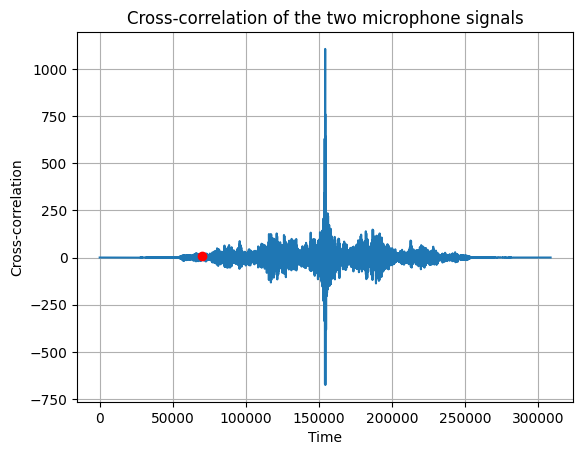

0.0006122448979591836
0.30000000000000004
340
0.8039363545746493
0.0006122448979591836
0.30000000000000004
340
0.8039363545746493
0 3
46.06216011426028
46.06216011426028
[27, 27]


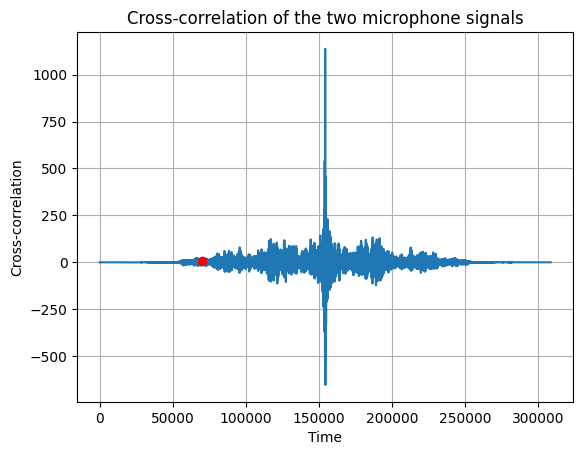

0.0008163265306122449
0.4
340
0.8039363545746491
0.0007936507936507937
0.4
340
0.8303693289879189
0 4
46.062160114260266
47.576657988117915
[36, 35]


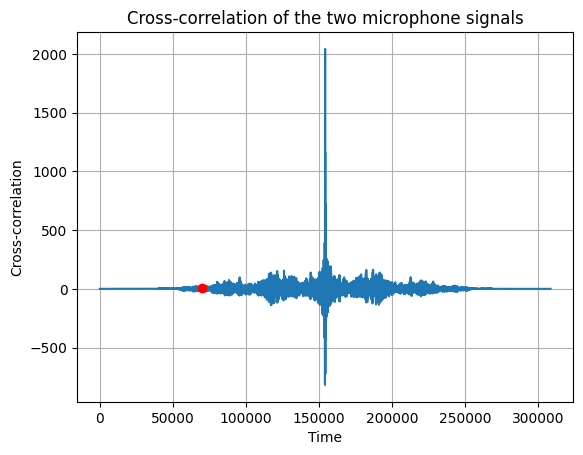

0.0
0.1
340
1.5707963267948966
-2.2675736961451248e-05
0.1
340
1.6479704157421002
1 2
90.0
94.421749584442
[0, -1]


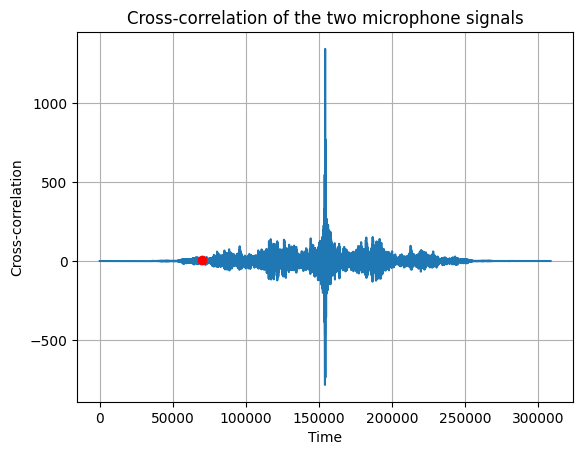

-0.00020408163265306123
0.2
340
1.925101495769374
-0.00020408163265306123
0.2
340
1.925101495769374
1 3
110.30019084190704
110.30019084190704
[-9, -9]


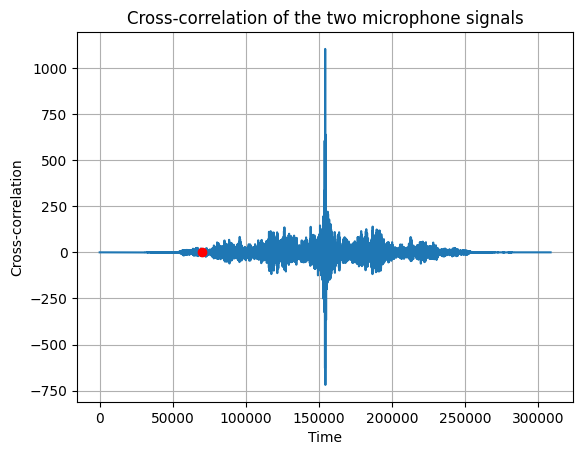

0.0006122448979591836
0.30000000000000004
340
0.8039363545746493
0.0005895691609977325
0.30000000000000004
340
0.8390386466368908
1 4
46.06216011426028
48.07337330066228
[27, 26]


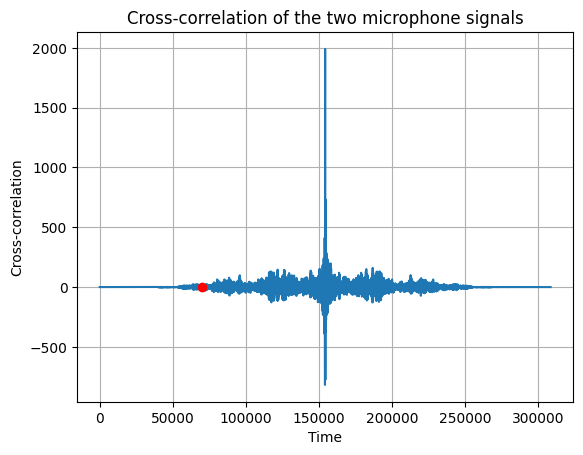

0.0
0.1
340
1.5707963267948966
-2.2675736961451248e-05
0.1
340
1.6479704157421002
2 3
90.0
94.421749584442
[0, -1]


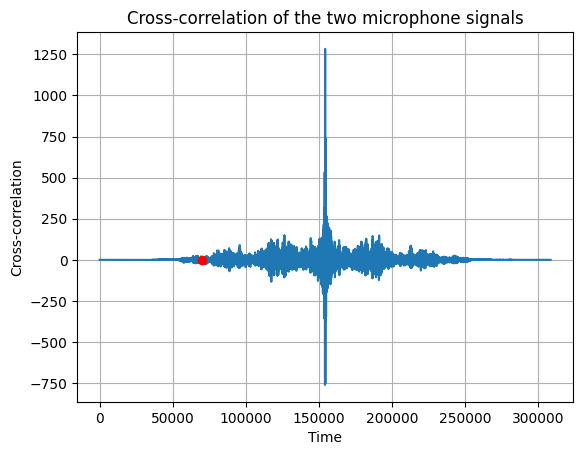

0.0003854875283446712
0.2
340
0.8561784923684185
0.0
0.2
340
1.5707963267948966
2 4
49.05541412258414
90.0
[17, 0]


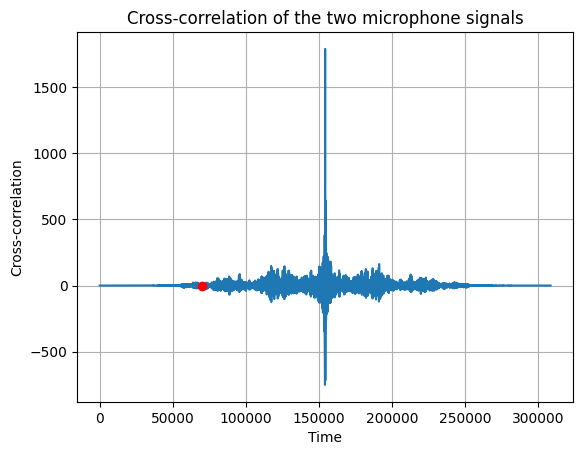

0.0
0.1
340
1.5707963267948966
-2.2675736961451248e-05
0.1
340
1.6479704157421002
3 4
90.0
94.421749584442
[0, -1]


In [254]:
from itertools import combinations
for mic1_num, mic2_num in combinations([x for x in range(0,len(mict))], 2):
    TDOA = TDOA_corr(mict[mic1_num], mict[mic2_num], n=2)
    d = (mic2_num-mic1_num)*0.1
    DOAestAll = DOA_corr(TDOA, acousticScenario.fs, d)
    print(mic1_num, mic2_num)
    print(DOAestAll[0]*180/np.pi)
    print(DOAestAll[1]*180/np.pi)
    print(TDOA)

In [ ]:
import scipy.io.wavfile as wav
import librosa
import librosa.display
import numpy as np
from scipy.signal import fftconvolve,resample,correlate
def create_micsigs_wav(MIRwavfiles, audio_src, noise_src):
    start_time = 2  # seconds
    end_time = 5    # seconds
    sample_rate_audio = []
    sample_rate_noise = []
    processed_audio = []
    processed_noise = []

    MIR_fs,MIR = wav.read(MIRwavfiles[0][0])
    for i in range(0,len(audio_src)):

        sample_rate_audio, audio = wav.read(audio_src[i])
        start_sample_audio = int(start_time * sample_rate_audio)
        end_sample_audio = int(end_time * sample_rate_audio)

        audio = audio[start_sample_audio:end_sample_audio]

        num_samples = int(len(audio)* MIR_fs/sample_rate_audio)
        unnorm_audio =resample(audio,num_samples)
        processed_audio.append(unnorm_audio / np.max(np.abs(unnorm_audio)))
    if len(noise_src) == 0:
        pass
    else:
        for i in range(0,len(noise_src)):
            sample_rate_noise, noise = wav.read(noise_src[i])
            start_sample_noise = int(start_time * sample_rate_noise)
            end_sample_noise = int(end_time * sample_rate_noise)

            noise = noise[start_sample_noise:end_sample_noise]

            num_samples = int(len(noise)* MIR_fs/sample_rate_noise)
            unnorm_noise =resample(noise,num_samples)
            processed_noise.append( unnorm_noise / np.max(np.abs(unnorm_noise)))



    mic = [0 for i in range(0,len(MIRwavfiles[0]))]
    for j in range (0,len(audio_src)):
        for i in range (0,len(MIRwavfiles[j])):
            #print(MIRwavfiles[j][i])
            MIR_fs,MIR = wav.read(MIRwavfiles[j][i])
            
            mic_audio = fftconvolve(processed_audio[j], MIR, mode='full')
            mic[i]= mic[i] + mic_audio
    for j in range (0,len(noise_src)):
        for i in range (0,len(MIRwavfiles[j])):
            MIR_fs,MIR = wav.read(MIRwavfiles[j][i])
            
            mic_noise = fftconvolve(processed_noise[j], MIR, mode='full')
            mic[i]= mic[i] + mic_noise
    norm_mic=  [mic[i] / np.max(np.abs(mic[i])) for i in range(0,len(mic))]

    """for j in range (0,len(audio_src)):
        mic_audio = fftconvolve(processed_audio[j], MIR, mode='full')
        mic_total = mic_total + mic_audio

    if acousticScenario.RIRsNoise is None:
        pass
    else:
        for j in range (0,len(noise_src)):
            mic_noise = fftconvolve(processed_noise[j], MIR, mode='full')
            mic_total = mic_total + mic_noise"""

            

    # Plot the array
    plt.plot(norm_mic[0])
    plt.plot(norm_mic[1])
    # Labels and title
    plt.xlabel('Time')
    plt.ylabel('Mic Signal')
    plt.title('Microphone 1 and 2')
    plt.grid()
    #plt.xlim([150, 180])
    # Show the plot
    plt.show()

    return norm_mic, processed_audio, processed_noise


44100


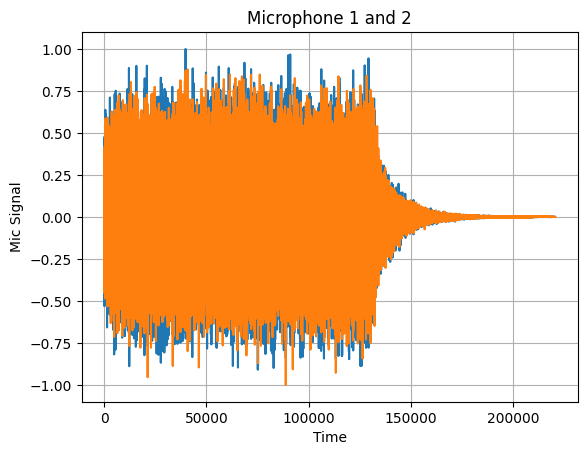

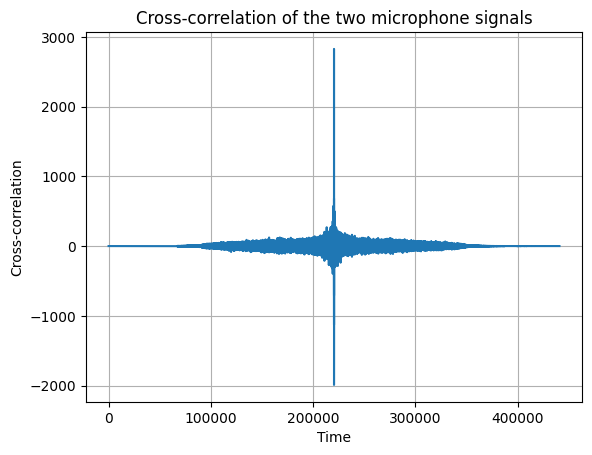

L1, L2
126.37429600085093
126.37429600085093


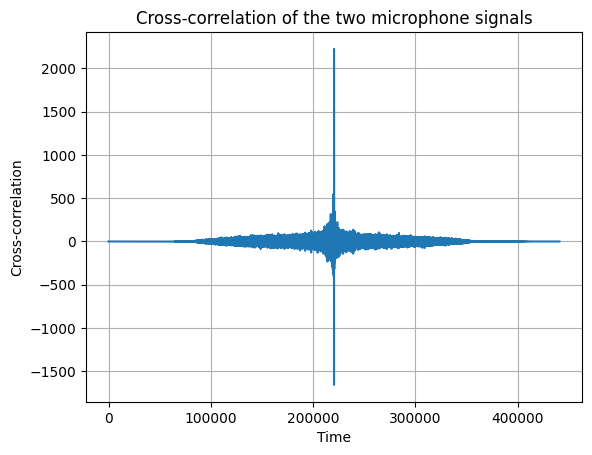

R1, R2
126.37429600085093
180.0


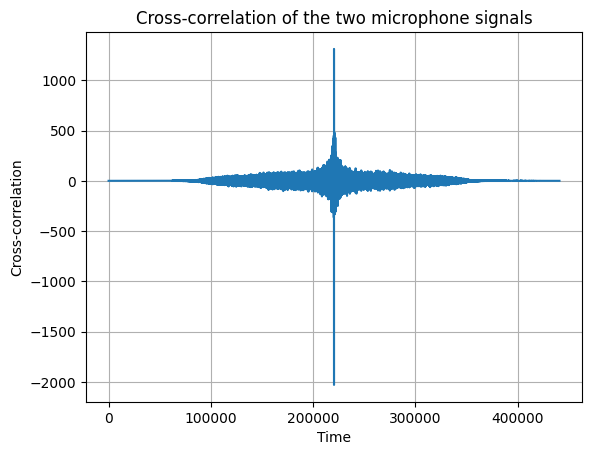

L1, R1
108.82833099485927
111.01381550114765


In [ ]:
print(acousticScenario.fs)
speechfilenames = [
    pathToSoundFiles + 'whitenoise_signal_2.wav',
    pathToSoundFiles + 'whitenoise_signal_2.wav'
]
noisefilenames = [

]

MIC_WAV = [
    [pathToSoundFiles+"head_mounted_rirs/s30/HMIR_L1.wav",
    pathToSoundFiles+"head_mounted_rirs/s30/HMIR_L2.wav",
    pathToSoundFiles+"head_mounted_rirs/s30/HMIR_R1.wav",
    pathToSoundFiles+"head_mounted_rirs/s30/HMIR_R2.wav"],
[pathToSoundFiles+"head_mounted_rirs/s-60/HMIR_L1.wav",
    pathToSoundFiles+"head_mounted_rirs/s-60/HMIR_L2.wav",
    pathToSoundFiles+"head_mounted_rirs/s-60/HMIR_R1.wav",
    pathToSoundFiles+"head_mounted_rirs/s-60/HMIR_R2.wav"]]


mict, aud, noise = create_micsigs_wav(MIC_WAV, speechfilenames, noisefilenames)
soundfile.write("output.wav", mict[0], acousticScenario.fs)

from itertools import combinations
"""for mic1_num, mic2_num in combinations([x for x in range(0,len(mict))], 2):
    TDOA = TDOA_corr(mict[mic1_num], mict[mic2_num], n=2)
    d = (mic2_num-mic1_num)*0.1
    DOAestAll = DOA_corr(TDOA, acousticScenario.fs, d)
    print(mic1_num, mic2_num)
    print(DOAestAll[0]*180/np.pi)
    print(DOAestAll[1]*180/np.pi)
    print(TDOA)"""
MIR_fs,MIR = wav.read(MIC_WAV[0][0])
TDOA = TDOA_corr(mict[0], mict[1], n=2)
d = 0.013
DOAestAll = DOA_corr(TDOA,MIR_fs , d)
print("L1, L2")
print(DOAestAll[0]*180/np.pi)
print(DOAestAll[1]*180/np.pi)


TDOA = TDOA_corr(mict[2], mict[3], n=2)
d = 0.013
DOAestAll = DOA_corr(TDOA, MIR_fs, d)
print("R1, R2")
print(DOAestAll[0]*180/np.pi)
print(DOAestAll[1]*180/np.pi)

TDOA = TDOA_corr(mict[0], mict[2], n=2)
d = 0.215
DOAestAll = DOA_corr(TDOA, acousticScenario.fs, d)
print("L1, R1")
print(DOAestAll[0]*180/np.pi)
print(DOAestAll[1]*180/np.pi)



TESTING WEEK 1

In [13]:
gui()

[INVALID VALUE] Please enter a room dimension larger than 2 metres.
[INVALID VALUE] Please enter a room dimension larger than 2 metres.
Note that the RIRs are sampled at 44100 Hz.
PyRoomAcoustics is computing the 5 RIRs...
RIRs computed successfully. Saving as Pickle archive.
RIRs saved in file: "rirs_20250218_10h12m40s.pkl.gz", in folder
"c:\Yani\Signal_Processing_Project\rirs"


44100


NameError: name 'create_micsigs' is not defined

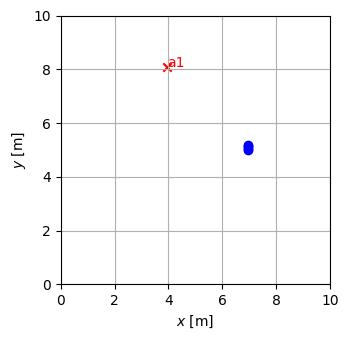

In [15]:
import matplotlib.pyplot as plt 
acousticScenario = build()

print(acousticScenario.fs)

speechfilenames = [
    pathToSoundFiles + 'part1_track1_dry.wav',
    pathToSoundFiles + 'part1_track2_dry.wav'
]
noisefilenames = [
]


mict, aud, noise = create_micsigs(acousticScenario, speechfilenames, noisefilenames)
soundfile.write("output.wav", mict[0], acousticScenario.fs)
TDOA = TDOA_corr(mict[0], mict[1], n=2, start = 463000, stop = 463100)
d = 0.1
DOAestAll = DOA_corr(TDOA, acousticScenario.fs, d)
#print("L1, R1")
print(DOAestAll[0]*180/np.pi)
print(DOAestAll[1]*180/np.pi)

# Signal processing - Week 2: MUSIC algorithm

In [5]:
import numpy as np

winLength = 1024 # Window length
nSources = acousticScenario.RIRsAudio.shape[-1] +\
    acousticScenario.RIRsNoise.shape[-1] # Number of sources
theta = np.arange(0, np.pi, step=np.pi / 360)  # angles to consider

print('Computing DOAs via freq.-domain MUSIC algorithm...')


# DOAestAll = yourMUSIC() ...
DOAestAll = np.zeros(nSources)  # default


print(f'All estimated DOAs: {DOAestAll * 180/np.pi}')

# ------------------ DOA estimation performance check ------------------
# Oracle selection of the target DOA
DOAest, oracleDOAtalkers = genfcns.oracle_choice_doa(
    DOAestAll, acousticScenario
)
print(f'Oracle-selected estimated DOAs: {DOAest * 180/np.pi}')
# Check validity
genfcns.check_plot_tdoas(DOAest, DOAestAll, acousticScenario)
print(f'Target DOAs estimate error(s): {np.round((DOAest - oracleDOAtalkers) * 180/np.pi, 1)} deg.')

AttributeError: 'NoneType' object has no attribute 'shape'

In [2]:
from scipy.signal import stft
import matplotlib
import soundfile
import os
import package.general as genfcns
import package.gui_utils as guifcns

[INVALID VALUE] Please enter a room dimension larger than 2 metres.
[INVALID VALUE] Please enter a room dimension larger than 2 metres.
Note that the RIRs are sampled at 44100 Hz.
PyRoomAcoustics is computing the 5 RIRs...
RIRs computed successfully. Saving as Pickle archive.
RIRs saved in file: "rirs_20250218_10h10m50s.pkl.gz", in folder
"c:\Yani\Signal_Processing_Project\rirs"


AttributeError: 'RIRg_GUI' object has no attribute 'micsCoords'

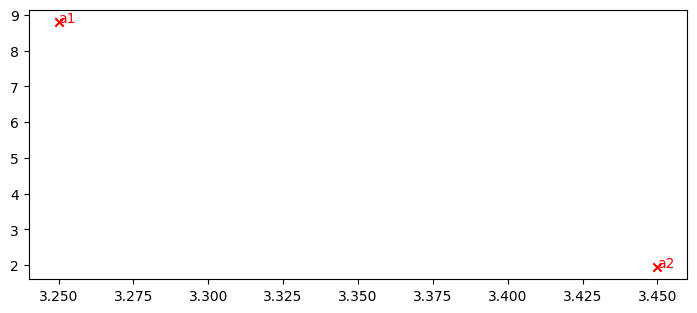

In [7]:
gui()
acousticScenario = build()


44100


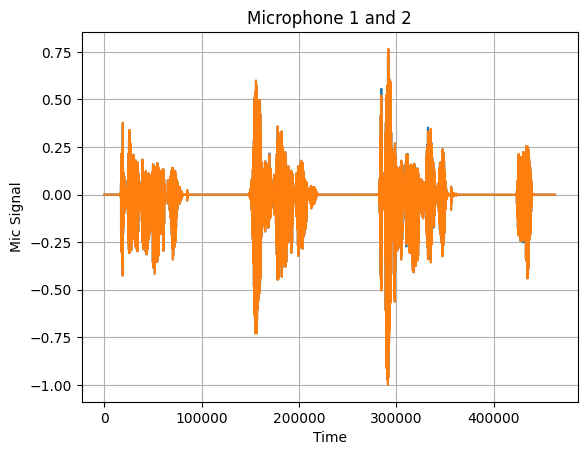

NameError: name 'TDOA_corr' is not defined

In [17]:

print(acousticScenario.fs)
speechfilenames = [
    pathToSoundFiles + 'speech1.wav'
]
noisefilenames = [
]


mict, aud, noise = create_micsigs(acousticScenario, speechfilenames, noisefilenames)
soundfile.write("output.wav", mict[0], acousticScenario.fs)
TDOA = TDOA_corr(mict[0], mict[1], n=1, start = 0, stop = -1)
d = 0.05
DOAestAll = DOA_corr(TDOA, acousticScenario.fs, d)
#print("L1, R1")
print(DOAestAll[0]*180/np.pi)
#print(DOAestAll[1]*180/np.pi)

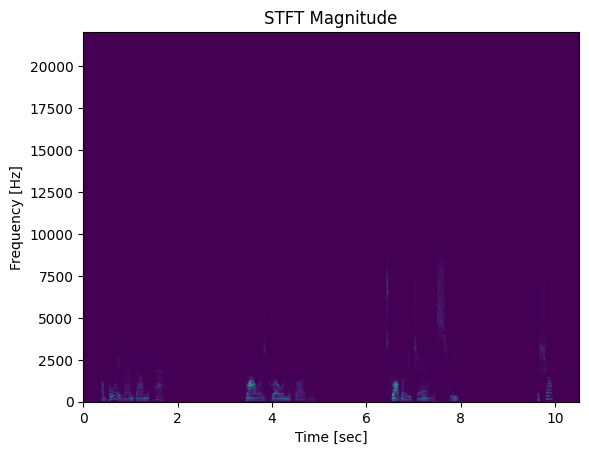

In [18]:
from scipy.signal import stft

if acousticScenario.fs == 44100:
    Y_STFT = []
    for mic in mict:
        f, t, Zxx = stft(mic, fs=acousticScenario.fs, nperseg=1024, noverlap=512)
        Y_STFT.append(Zxx)
    Y_STFT = np.array(Y_STFT)
    plt.pcolormesh(t, f, np.abs(Zxx), shading='gouraud')
    plt.title('STFT Magnitude')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.show()
else:
    print('STFT not available for this sampling frequency.')

In [19]:
print(len(Y_STFT))
print(Y_STFT.shape)
len(t)

5
(5, 513, 906)


906

In [28]:
def music_narrowband(Y_STFT, f):
    c = 340  # Speed of sound [m/s]
    fs = 44100  # Sampling frequency [Hz]
    # Compute average power per frequency bin across microphones and time frames
    avg_power = None
    for Z in Y_STFT:
        # For each microphone: compute the power (squared magnitude) and average over time frames (axis=1)
        power_per_freq = np.mean(np.abs(Z)**2, axis=1)
        if avg_power is None:
            avg_power = power_per_freq
        else:
            avg_power += power_per_freq
    avg_power /= len(Y_STFT)

    # Use the frequency vector 'f' to select the frequency bin with highest average power
    idx_max = np.argmax(avg_power)
    omega_max = f[idx_max]
    print("Frequency bin with highest power:", omega_max)
    

    nSources = len(Y_STFT)
    # Compute the covariance matrix of the observed signals
    R = np.zeros((nSources, nSources), dtype=complex)
    for i in range(0,Y_STFT.shape[1]):
        # For each time frame: compute the cross-spectral density matrix
        R = np.outer(Y_STFT[:,i,:], np.conj(Y_STFT[:,i,:])).T
    #R = np.outer(Y_STFT[:,:,:], Y_STFT[:,:,:].conj.T)
    R /= Y_STFT[0].shape[1]
    #R = np.outer(Y_STFT[:,:,:], np.conj(Y_STFT[:,:,:]).T)#.mean(axis=1)
    print(R.shape)

    # Define theta range
    theta = np.arange(0, np.pi, step=np.pi / 360)
     

    # Compute the MUSIC pseudospectrum
    _, E = np.linalg.eigh(R)
    P = np.zeros(len(theta))
    for i, th in enumerate(theta):
        g = np.exp(-1j * np.arange(nSources)[:, np.newaxis] * 2 * np.pi * f * fs * d * np.cos(th) / c)

        #g = np.exp(-1j * np.arange(nSources) * 2 * np.pi * f * fs * d* np.cos(th)/c) 
        P[i] = 1 / np.abs(g.conj().T @ E[:, :-nSources] @ E[:, :-nSources].conj().T @ g)


    plt.plot(theta, 10 * np.log10(P / np.max(P)))
    plt.title('Pseudospectrum')
    plt.ylabel('P_theta [dB]')
    plt.xlabel('theta [rad]')
    plt.show()
    return P
    

In [37]:
Y_STFT.shape

(5, 513, 906)

In [29]:
P = music_narrowband(Y_STFT, f)


Frequency bin with highest power: 215.33203125
(4530, 4530)


NameError: name 'd' is not defined